# Day 17

In [352]:
%cd ..

from inspect import cleandoc
from matplotlib import pyplot
import ipytest
ipytest.autoconfig()

/home/vagrant/Development/advent-of-code-2022


In [353]:
example = ">>><<><>><<<>><>>><<<>>><<<><<<>><>><<>>"

In [354]:
from aocd import get_data
data = get_data(year=2022, day=17)

In [396]:
from collections import defaultdict
from dataclasses import dataclass
from enum import Enum
from functools import cached_property
from itertools import cycle, islice
from aoc22.geometry import Direction, Point

def parse_jet_pattern(text: str) -> list[Direction]:
    return [
        Direction.L if c == "<" else Direction.R
        for c in text
    ]

class RockType(Enum):
    HBAR = {(0, 0), (1, 0), (2, 0), (3, 0)}
    PLUS = {(0, -1), (1, 0), (1, -1), (1, -2), (2, -1)}
    L = {(0, 0), (1, 0), (2, 0), (2, -1), (2, -2)}
    VBAR = {(0, 0), (0, -1), (0, -2), (0, -3)}
    SQUARE = {(0, 0), (0, -1), (1, 0), (1, -1)}
    
    @cached_property
    def color(self):
        COLORS = {
            RockType.HBAR: (0, 255, 255),
            RockType.PLUS: (127, 0, 255),
            RockType.L: (255, 127, 0),
            RockType.VBAR: (0, 0, 255),
            RockType.SQUARE: (255, 255, 0),
        }
        return COLORS[self]
    
    def image(self):
        NOTHING = (0, 0, 0)
        color = self.color
        
        return [
            [
                color if (x, y) in self.value else NOTHING
                for x in range(0, 4)
            ]
            for y in range(-3, 1)
        ]

@dataclass
class Rock:
    rock_type: RockType
    position: Point
    
    @cached_property
    def points(self):
        return {Point(xs) + self.position for xs in self.rock_type.value}
    
    @cached_property
    def color(self):
        return self.rock_type.color
        
    def __add__(self, direction: Direction):
        return Rock(self.rock_type, self.position + direction)
    
    def collides_with_floor(self) -> bool:
        return 0 in {y for _, y in self.points}
    
    def collides_with_wall(self, chamber) -> bool:
        return not {-1, chamber.WIDTH}.isdisjoint({x for x, _ in self.points})
    
    def collides_with_tower(self, chamber) -> bool:
        return any(
            p.x in chamber.tower[p.y]
            for p in self.points
        )
    
    def collides_with(self, chamber: VerticalChamber) -> bool:
        return (
            self.collides_with_wall(chamber)
            or self.collides_with_floor()
            or self.collides_with_tower(chamber)
        )
    
class VerticalChamber:
    WIDTH = 7

    def __init__(self, jet_pattern: list[Direction]):
        self.tower = defaultdict(set)
        self.rock_production = cycle(RockType)
        self.jet_pattern = cycle(jet_pattern)
        self.height = 0
        self.dhs = []
        self.next_rock()
        self.rock_count = 0
        
    def next_rock(self):
        self.current_rock = Rock(next(self.rock_production), Point(2, -self.height - 4))
    
    def stop_current_rock(self):
        old_height = self.height
        self.height = max(self.height, max(-y for _, y in self.current_rock.points))
        self.dhs.append(self.height - old_height)
        for p in self.current_rock.points:
            self.tower[p.y].add(p.x)
        self.next_rock()
        self.rock_count += 1
        
    def run_step(self):
        d = next(self.jet_pattern)
        new_rock = self.current_rock + d
        if not new_rock.collides_with(self):
            self.current_rock = new_rock
        
        new_rock = self.current_rock + Direction.D

        if not new_rock.collides_with(self):
            self.current_rock = new_rock
        else:
            self.stop_current_rock()
    
    def run_rocks(self, n=2022):
        while self.rock_count < n:
            self.run_step()
        return self.height

    def image(self):
        NOTHING = (0, 0, 0)
        FRAME = (255, 255, 255)
        TOWER = (127, 127, 127)
        
        if self.current_rock:
            color = self.current_rock.color
        else:
            color = NOTHING
        
        return [
            [
                FRAME if x in [-1, self.WIDTH] or y == 0
                else TOWER if x in self.tower[y]
                else color if self.current_rock and Point(x, y) in self.current_rock.points
                else NOTHING
                for x in range(-2, self.WIDTH+2)
            ]
            for y in range(-self.height-5, 2)
        ]


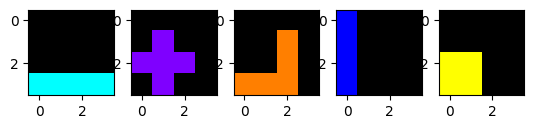

In [397]:
fig = pyplot.figure()
rows, columns = 1, 5

for i, t in enumerate(RockType, start=1):
    fig.add_subplot(rows, columns, i)
    pyplot.imshow(t.image())

In [398]:
example_chamber = VerticalChamber(parse_jet_pattern(example))

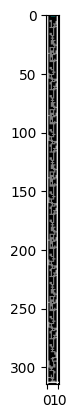

In [399]:
example_chamber.run_rocks(200)
pyplot.imshow(example_chamber.image())

In [400]:
[
    p
    for p in range(1, len(example) * 5)
    if sum(
        x - y > 0
        for x, y in zip(example_chamber.dhs, example_chamber.dhs[p:])
    ) <= 10
][:10]

[35, 70, 105, 140, 175, 176, 179, 180, 181, 182]

In [419]:
data_chamber = VerticalChamber(parse_jet_pattern(data))

In [420]:
data_chamber.run_rocks(1110)

1666

In [421]:
data_chamber.run_rocks(1110+1735)

4377

In [422]:
(1000000000000 - 1110) // 1735, (1000000000000 - 1110) % 1735

(576368875, 765)

In [423]:
data_chamber.run_rocks(1110+1735+765)

5552

In [424]:
5552-4377

1175

In [425]:
576368875 * (4377-1666) + 1666 + 1175

1562536022966

In [407]:
[
    p
    for p in range(1, len(data))
    if sum(
        x - y > 0
        for x, y in zip(data_chamber.dhs, islice(data_chamber.dhs, p, None))
    ) <= 1000
][:10]

[1735]

In [406]:
len(data)

10091

In [417]:
[
    x - y
    for x, y in zip(data_chamber.dhs, islice(data_chamber.dhs, 1735, None))
][1110:]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
